In [1]:
from scipy.spatial.distance import euclidean, pdist, squareform
from scipy.stats.mstats import zscore
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
from sklearn.decomposition import PCA
import scipy, json, csv, time
import numpy as np
import pandas as pd
#%matplotlib notebook

In [2]:
def pca_results(good_data, pca):
    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (10,10))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

In [3]:
def vis_PCA3D(color, colormap, title):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection="3d")
    # scatterplot of the reduced data    
    ax.scatter(xs=reduced_data[0], ys=reduced_data[1], zs=reduced_data[2], s=5, alpha=0.5, c=color, cmap=colormap)

    feature_vectors = pca.components_.T

    # we use scaling factors to make the arrows easier to see
    arrow_size, text_pos = 7.0, 8.0,

    # projections of the original features
    for i, v in enumerate(feature_vectors):
        ax.plot([0,arrow_size*v[0]], [0,arrow_size*v[1]], zs=[0,arrow_size*v[2]])
        ax.text(v[0]*text_pos, v[1]*text_pos, v[2]*text_pos, df.columns[i], color="black", ha="center", va="center", fontsize=10)

    ax.set_title("PC plane with original feature projections.", fontsize=16);
    ax
    #plt.savefig("/vectors3DPer{0}.png".format(title), dpi = 300)

In [4]:
df = pd.read_csv('baseline_def_kaggle.csv')
#df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()
np.random.seed(40)

In [5]:
feature_names = ['close', 'volume', 'market', 'spread', 'percentChange']
data = df[feature_names]
data.head()

,close,volume,market,spread,percentChange
0,735.07,46862700.0,8.955395e+09,63.91,0.000000
1,727.83,32505800.0,8.869919e+09,41.71,-0.009849
2,745.05,19011300.0,9.082104e+09,34.17,0.023659
3,756.13,20707700.0,9.217168e+09,26.36,0.014871
4,754.01,20897300.0,9.191325e+09,22.41,-0.002804


In [6]:
def baseline_colors(x):
    if x:
        return 'Firebrick'
    else:
        return 'ForestGreen'

colors_2sd = df['isEvent based on 2SD'].apply(baseline_colors).values
colors_percent = df['isEvent based on 2SD'].apply(baseline_colors).values

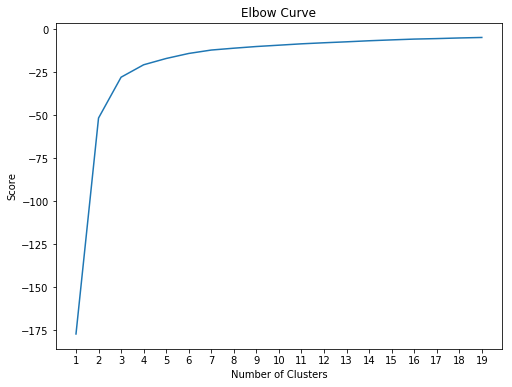

In [7]:
data2 = data.copy()
data2 = data2.reset_index(drop=True)

data2[:] = MinMaxScaler().fit_transform(data2[:])
pca = PCA(n_components=2)
pca.fit(data2)
reduced_data = pca.transform(data2)
reduced_data = pd.DataFrame(reduced_data)

num_clusters = range(1, 20)

kmeans = [KMeans(n_clusters=i).fit(reduced_data) for i in num_clusters]
scores = [kmeans[i].score(reduced_data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(num_clusters, scores)
plt.xticks(num_clusters)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

From this we can see the best number of clusters to use is 4.

In [8]:
#Choosing the best number of clusters based on the elbow curve
best_num_cluster = 4
km = KMeans(n_clusters=best_num_cluster)
km.fit(reduced_data)
km.predict(reduced_data)
labels = km.labels_

Text(0.5,1,'Clusters based on K means')

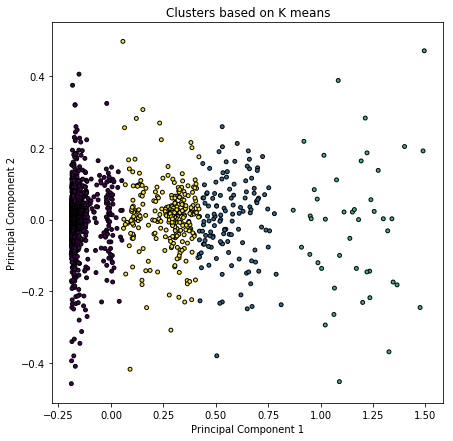

In [9]:
#Plotting based on cluster
fig = plt.figure(1, figsize=(7,7))
plt.scatter(reduced_data.iloc[:,0], reduced_data.iloc[:,1], 
            c=labels.astype(np.float), edgecolor="k", s=15)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters based on K means')

Text(0.5,1,'Clusters based on K means')

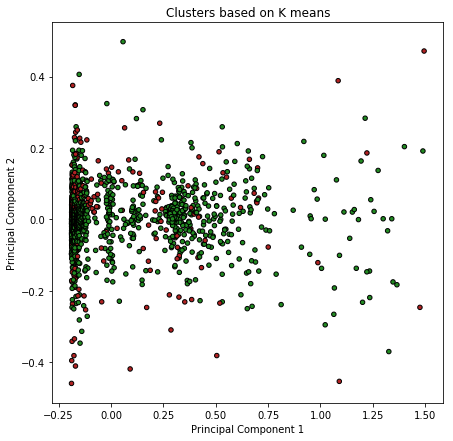

In [10]:
#Plotting based on 2SD Event
fig = plt.figure(1, figsize=(7,7))
plt.scatter(reduced_data.iloc[:,0], reduced_data.iloc[:,1], 
            c=colors_2sd, edgecolor="k", s=20)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters based on K means')

Text(0.5,1,'Clusters based on K means')

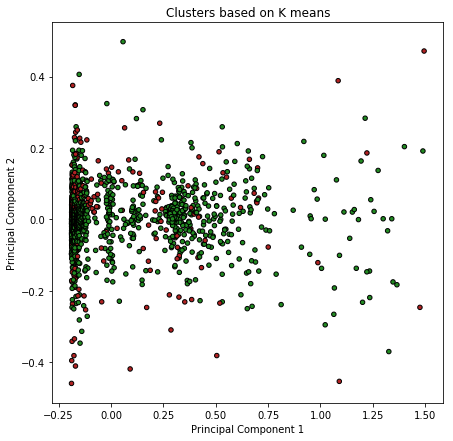

In [11]:
#Plotting based on percent event
fig = plt.figure(1, figsize=(7,7))
plt.scatter(reduced_data.iloc[:,0], reduced_data.iloc[:,1], 
            c=colors_percent, edgecolor="k", s=20)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters based on K means')

In [12]:
#Plotting for 3 Principal Components
#fig = plt.figure(1, figsize=(7,7))
#ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=90, azim=0)
#ax.scatter(reduced_data.iloc[:,0], reduced_data.iloc[:,1], reduced_data.iloc[:,2],
 #        c=labels.astype(np.float), edgecolor="k")
         #  c=colors_percent, edgecolor="k", s=10)
#ax.set_xlabel("X")
#ax.set_ylabel("Y")
#ax.set_zlabel("Z")
#plt.title("Clusters Based on KMeans", fontsize=20)

In [13]:
reduced_data.loc[0]

0   -0.156549
1   -0.004556
Name: 0, dtype: float64

In [14]:
mod = kmeans[best_num_cluster-1]
mod.cluster_centers_

array([[ 2.69543512e-01,  7.90047831e-03],
       [ 5.64451695e-01, -2.28757734e-03],
       [-1.56719627e-01, -9.62245725e-04],
       [ 1.15794618e+00, -1.79173887e-02]])

In [15]:
reduced_data['Principal Component 1'] = reduced_data[0]
reduced_data['Principal Component 2'] = reduced_data[1]
reduced_data.drop(columns = [0, 1], inplace=True)
reduced_data.head()

,Principal Component 1,Principal Component 2
0,-0.156549,-0.004556
1,-0.158667,-0.025136
2,-0.158063,0.046794
3,-0.158000,0.028196
4,-0.158546,-0.009534


Threshold: 1.0269020316963218


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Text(0,0.5,'principal feature 2')

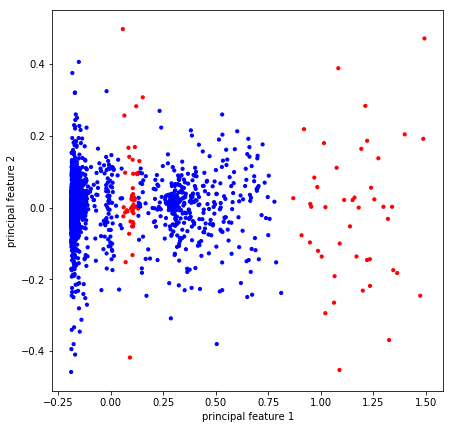

In [16]:
def getDistanceByPoint(data, model):
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
    return distance

outliers_fraction = 0.05
# find the distance between each point and its nearest centroid. The largest distances will be consdiered anomalies
distance = getDistanceByPoint(reduced_data, kmeans[best_num_cluster-1])
distance = pd.Series(distance)
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
print('Threshold:', threshold)

# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
data['anomaly1'] = (distance >= threshold).astype(int)

# visualisation of anomaly with cluster view
#fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
plt.figure(figsize=(7,7))
plt.scatter(reduced_data.iloc[:,0], reduced_data.iloc[:,1], 
            c=data["anomaly1"].apply(lambda x: colors[x]), s=10)
plt.xlabel('principal feature 1')
plt.ylabel('principal feature 2')


In [17]:
data['anomaly1'].value_counts()

0    1710
1      89
Name: anomaly1, dtype: int64

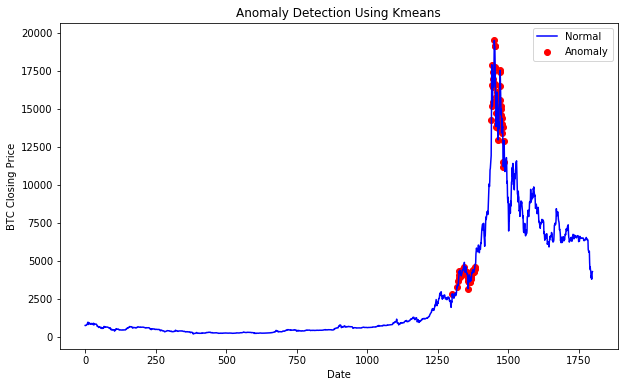

In [18]:
fig, ax = plt.subplots(figsize=(10,6))
a = data.loc[data['anomaly1'] == 1,]

ax.plot(data['close'], color='blue', label = 'Normal')
ax.scatter(a.index, a['close'], color='red', label = 'Anomaly')
plt.legend()
plt.title("Anomaly Detection Using Kmeans")
plt.xlabel('Date')
plt.ylabel('BTC Closing Price')
plt.show();


In [19]:
#pca_results(correlations, pca)

In [20]:
#vis_PCA3D(color=labels.astype(np.float), colormap=None, title="3D PCA Visualization")